In [1]:
from src.model.pl_modules import RacingF1Detector
from src.data.datasets import RacingF1Dataset
from src.data.pl_data_modules import RacingF1DataModule
from pytorch_lightning import Trainer
from torchvision import transforms
import torch

In [2]:
augmentation = torch.nn.Sequential(
	transforms.Resize((150, 150))
)

data_module = RacingF1DataModule(32, 'dataset/', val_subdirs=['racing-1-val'],
								 				 test_subdirs=['racing-1-test'],
								 				 train_subdirs=['racing-1-train'], data_transform=augmentation)
data_module.setup('fit')

In [3]:
data_loader = data_module.train_dataloader()

In [13]:
image, image_with_bounding_box = data_module.train_dataset.show_image(956)

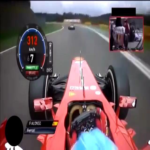

In [14]:
display(image)

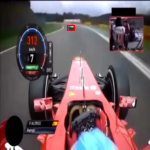

In [15]:
display(image_with_bounding_box)

In [13]:
hparams = { "kernel_size": 3 }
detector = RacingF1Detector(hparams)

In [ ]:
trainer = Trainer()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(detector, data_loader)

/home/andrea/miniconda3/envs/cv-project/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:118: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name              | Type       | Params
-------------------------------------------------
0 | loss_function     | MSELoss    | 0     
1 | conv_layers       | Sequential | 370 K 
2 | regression_layers | Sequential | 471 M 
-------------------------------------------------
472 M     Trainable params
0         Non-trainable params
472 M     Total params
1,888.962 Total estimated model params size (MB)
/home/andrea/miniconda3/envs/cv-project/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argum

Epoch 0:   0%|          | 0/31 [00:00<?, ?it/s] ----------------------------------------------------------------------------------------------------
tensor([[0.5457, 0.4658, 0.4596, 0.4533],
        [0.5458, 0.4657, 0.4595, 0.4533]], grad_fn=<SliceBackward0>)
tensor([254, 254])
tensor([55, 55])
tensor([21, 22])
tensor([11, 10])
{'x': tensor([254, 254, 254, 254, 253, 253, 254, 254, 254, 256, 257, 258, 258, 259,
        259, 259, 258, 258, 259, 259, 259, 260, 260, 260, 260, 259, 260, 260,
        260, 261, 263, 265]), 'y': tensor([55, 55, 54, 56, 55, 55, 56, 56, 56, 55, 55, 55, 54, 55, 55, 55, 54, 54,
        54, 56, 55, 55, 55, 56, 55, 55, 55, 57, 56, 55, 56, 57]), 'width': tensor([21, 22, 22, 22, 22, 22, 21, 22, 21, 22, 21, 21, 22, 21, 22, 22, 22, 22,
        21, 22, 23, 21, 23, 23, 23, 22, 21, 22, 22, 22, 22, 22]), 'height': tensor([11, 10, 12,  9, 10, 11, 10, 10, 11, 11, 12, 12, 13, 12, 11, 12, 12, 11,
        10, 10, 11, 10, 10, 10, 10,  9, 10, 10, 10, 10,  9,  9])}
----------------

AttributeError: 'dict' object has no attribute 'size'